<a href="https://colab.research.google.com/github/Amelbnmbh/Text-to-image/blob/main/TTI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image
import numpy as np
from transformers import CLIPTextModel, CLIPTokenizer
from torch import autocast
import matplotlib.pyplot as plt
from torchvision import transforms

In [ ]:
# Charger le modèle Stable Diffusion (modèle version 1-5)
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id)

# Vérifier si CUDA est disponible et charger le modèle sur le bon périphérique
pipe.to("cuda" if torch.cuda.is_available() else "cpu")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
# Texte du prompt pour générer l'image
prompt = "Un dragon majestueux volant dans un ciel orageux avec des éclairs, style peinture réaliste"

# Charger le tokenizer pour transformer le texte en tokens
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# Tokenisation et génération des embeddings du texte
input_ids = tokenizer(prompt, return_tensors="pt").input_ids
with torch.no_grad():
    text_embeddings = text_encoder(input_ids).last_hidden_state

In [ ]:
# Définir les paramètres de génération
guidance_scale = 7.5  # Augmenter pour plus de cohérence avec le texte
num_inference_steps = 50  # Nombre de pas d'inférence pour améliorer la qualité de l'image
seed = 42  # Fixer la graine pour rendre les résultats reproductibles
torch.manual_seed(seed)  # Fixer la graine pour les générateurs aléatoires
generator = torch.manual_seed(seed)

In [ ]:
# Générer l'image
image = pipe(
    prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    generator=generator,
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
from PIL import Image, ImageFilter
# If image is a PIL Image object (check by printing its type):
if isinstance(image, Image.Image):
    image = image.convert("RGB")  # Convert to RGB (PIL Image format)
else:
    # If the image is already a numpy array, convert it back to a PIL image
    image = Image.fromarray(image).convert("RGB")  # Convert numpy array to PIL Image and RGB

# Now `image` is a PIL Image, you can convert it to numpy if needed
image = np.array(image)

# Convert numpy array back to PIL Image before applying any transformations
image_pil = Image.fromarray(image)

# Apply sharpening filter using Pillow
sharpness = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale if needed
    transforms.Lambda(lambda img: img.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3)))  # Apply sharpness filter
])

image_sharp = sharpness(image_pil)


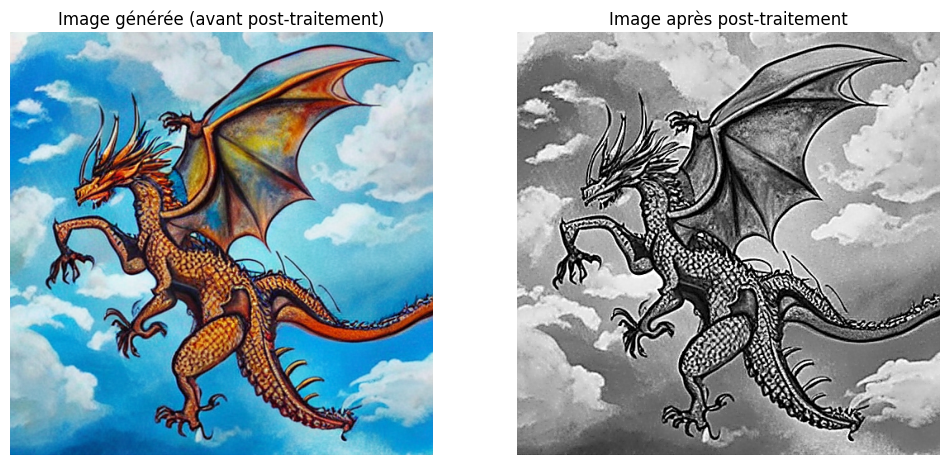

In [ ]:
# Affichage de l'image avant et après le post-traitement
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Image avant le post-traitement
axes[0].imshow(np.array(image_pil))
axes[0].set_title("Image générée (avant post-traitement)")
axes[0].axis("off")

# Image après le post-traitement
axes[1].imshow(np.array(image_sharp))
axes[1].set_title("Image après post-traitement")
axes[1].axis("off")

plt.show()